In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RegressionModel, self).__init__()
        self.n_train = 0
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, output_dim)
        )

    def forward(self, x):
        return self.fc(x)


In [8]:
def load_model_parameters(settings:dict):
    model = torch.load(f"{settings}/model.pt")
    model.eval()
    X_test = torch.load(f"{settings}/X_test.pt")
    y_test = torch.load(f"{settings}/y_test.pt")
    return model, X_test, y_test

In [6]:
def calculate_neutrino_angles(y_test, y_pred):
    # Create empty array to store MCreconu_angles in
    MCreconu_angle = np.empty((0,1))

    # Cycle through the test data
    for i in range(len(y_pred)):
        # Determine MC momentum
        MCnu_momentum = np.array([y_test[i][1], y_test[i][2], y_test[i][3]])
        # Determine reco momentum
        reconu_direction = np.array([y_pred[i][1], y_pred[i][2], y_pred[i][3]])
        # Calculate angle and store in array
        MCreconu_angle = np.append(MCreconu_angle, calculate_vector_angle(reconu_direction, MCnu_momentum))

    return MCreconu_angle

In [5]:
def calculate_vector_angle(vector_a:np.array, vector_b:np.array):
    return np.rad2deg(np.arccos((np.dot(vector_a, vector_b))/(np.linalg.norm(vector_a) * np.linalg.norm(vector_b))))

In [7]:
def angle_energy_histograms(MCreconu_angle, reco_energy, stat, ax):
    for data, bins, binrange, iax, xlabel in zip([MCreconu_angle, reco_energy, reco_energy],
                                        [100, 200, 100],
                                        [None, None, [-1.5, 1.5]],
                                        ax,
                                        [r'$\theta = \left| \angle\left( P_{MC}, P_{reco}\right) \right|$ in degrees', r"$E_{MC}-E_{reco}$ (GeV)", r"$E_{MC}-E_{reco}$ (GeV)"]):
        sns.histplot(data, ax=iax, element='step', fill=False, bins=bins, binrange=binrange, stat=stat, label=f"{settings['event_type']} - {settings['loss_function']}")
        iax.set_xlabel(xlabel)
        iax.legend()

In [12]:
def angle_reco_binned(ax):
    x = y_test[:,0]
    #x = np.array(y_pred[:,0])
    y = MCreconu_angle
    bin_means, bin_stds, bin_centers = calculate_means_scatterplot_log(x, y, num_bins=15)
    ax.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o', alpha=0.9, color="red")
    sns.histplot(x=y_test[:,0], ax=ax, y=MCreconu_angle, bins=40, cbar=True, cmap="viridis", log_scale=(True, False))
    

    
    ax.set_xlabel(r'True neutrino energy $\nu_{i, E}$ (GeV)')
    ax.set_xscale('log')
    ax.set_xlim(10**-1, 10**2)
    ax.set_ylabel(r'$\theta = \left| \angle\left( P_{MC}, P_{reco}\right) \right|$ in degrees')
    ax.set_title(f"{settings['event_type']}, {settings['loss_function']}")
    ax.hlines(y=0, xmin=10**-1, xmax=10**2, color='grey', linestyle='dotted')

In [11]:
def calculate_means_scatterplot_log(x: np.array, y: np.array, num_bins: int):
    bin_edges = np.logspace(np.log10(min(x)), np.log10(max(x)), num_bins + 1)
    bin_indices = np.digitize(x, bin_edges)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    bin_means = []
    bin_stds = []
    for i in range (1, num_bins + 1):
        mean, std = fit_gaussian_bin(y[bin_indices == i])
        bin_means.append(mean)
        bin_stds.append(std)

    return bin_means, bin_stds, bin_centers


In [10]:
def fit_gaussian_bin(x):
    import scipy
    y_data, bin_edges = np.histogram(x, bins=50, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    p0 = [np.mean(x), np.std(x), 1]  # Initial guess for parameters: mean, standard deviation, amplitude
    popt, pcov = scipy.optimize.curve_fit(gaussian, bin_centers, y_data, p0=p0, maxfev=800)
    return popt[0], popt[1]

In [9]:
def gaussian(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

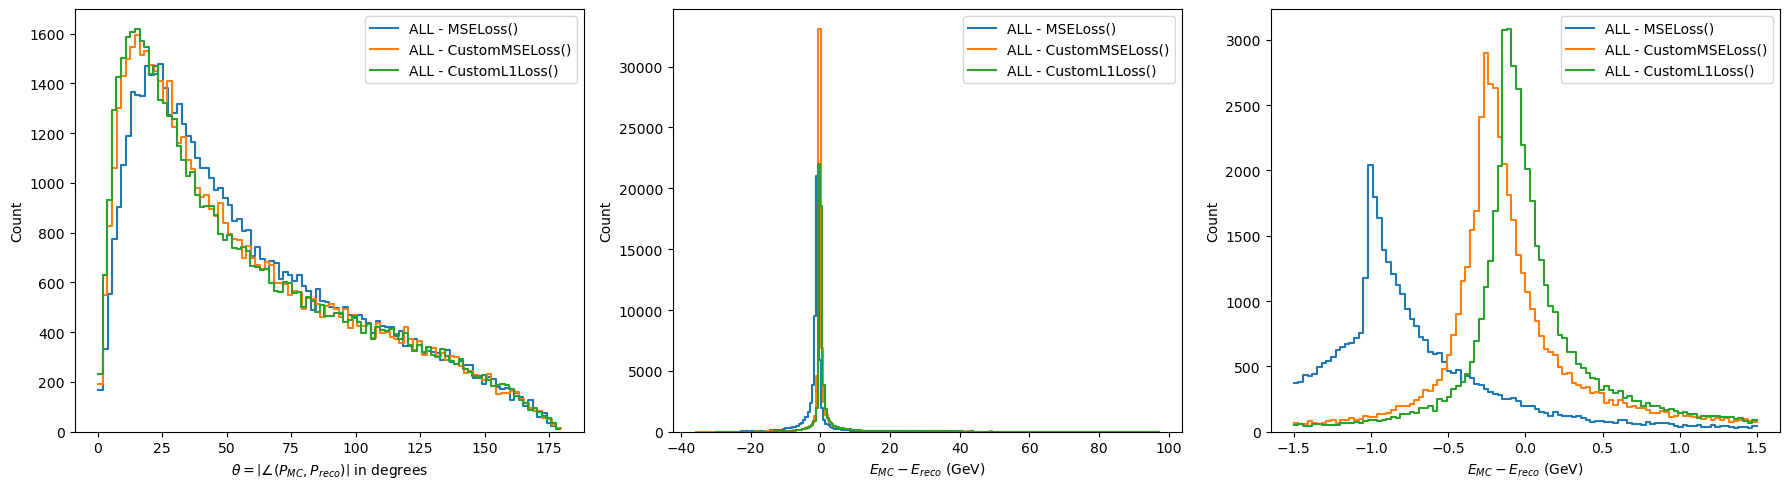

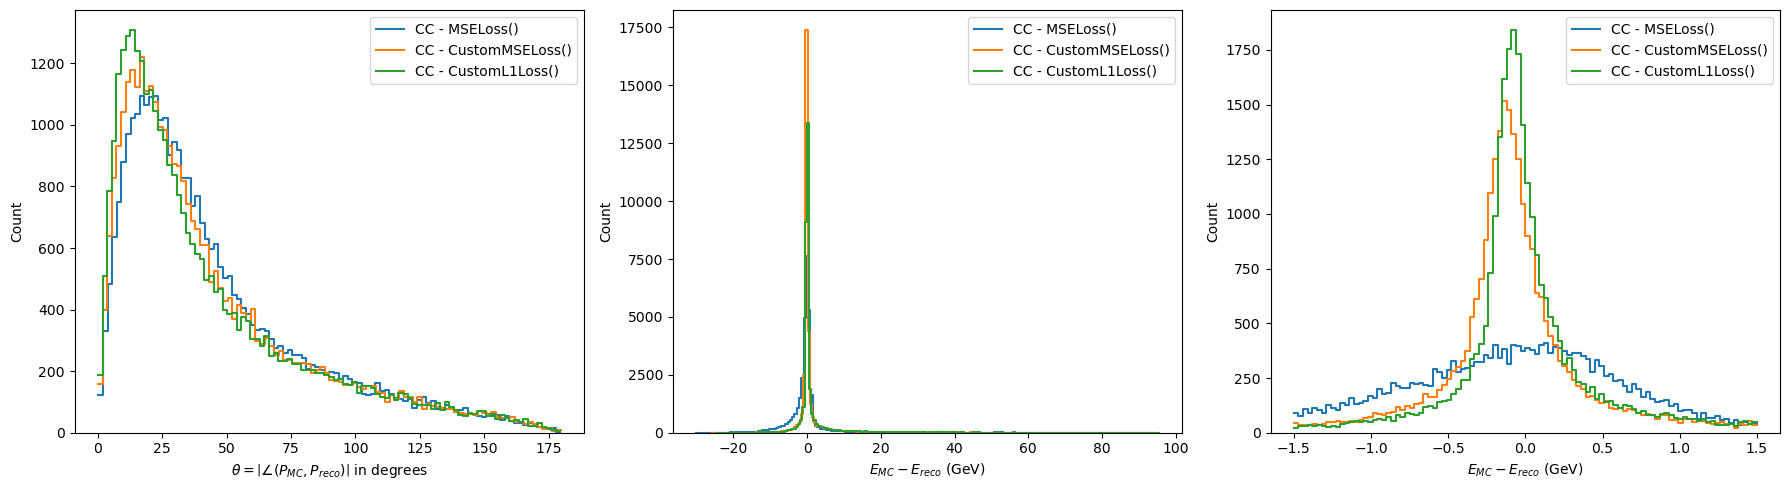

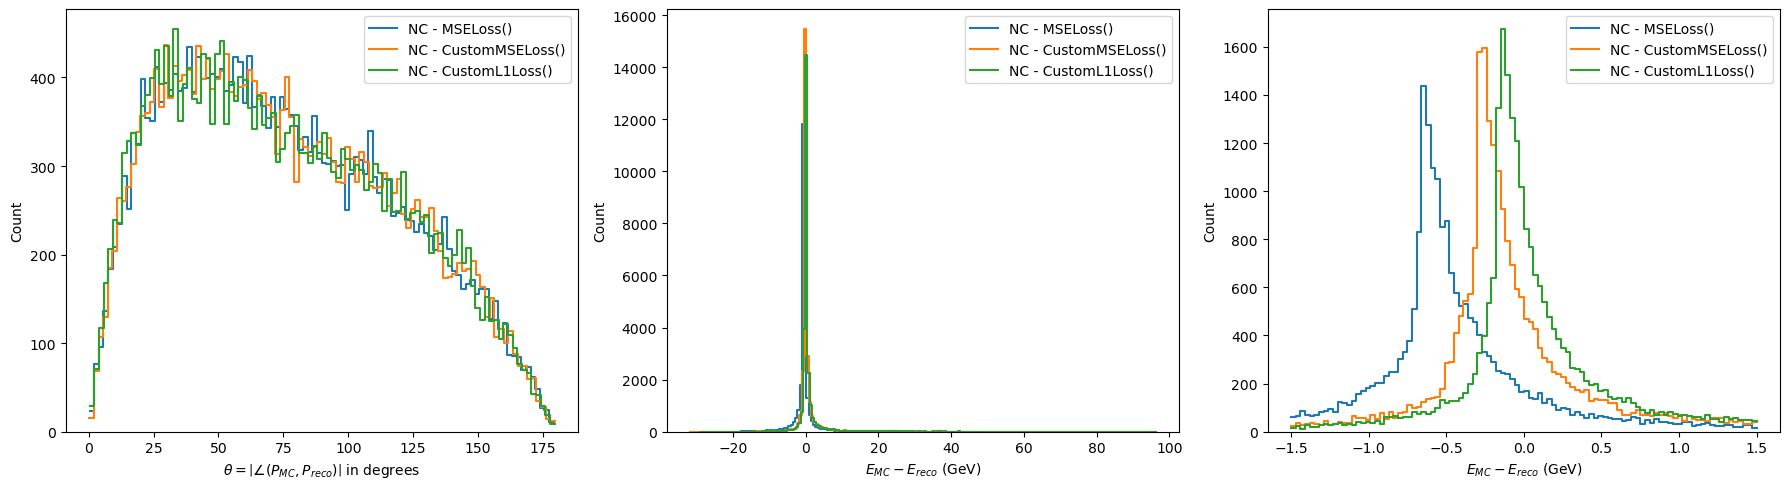

In [13]:
for event_type in ["ALL", "CC", "NC"]:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
    for loss_function, event_type, i in zip([nn.MSELoss(), CustomMSELoss(), CustomL1Loss()], [event_type, event_type, event_type], [0, 1, 2]):
            settings = {
            "event_type": event_type, # "CC", "NC", or "ALL"
            "epochs": 50,
            "batch_size": 100,
            "loss_function": loss_function # nn.MSELoss() or CustomMSELoss() or CustomL1Loss()
            }
    
            model, X_test, y_test = load_model_parameters(settings)
            
            with torch.no_grad():
                y_pred = model(torch.tensor(X_test, dtype=torch.float32))
            
            MCreconu_angle  = calculate_neutrino_angles(y_test, y_pred)
            
            reco_energy = y_test[:,0] - np.array(y_pred[:,0])
            angle_energy_histograms(MCreconu_angle, reco_energy, "count", ax=ax)
            #angle_reco_binned(ax=ax[1, i])
    plt.tight_layout()
    plt.show()

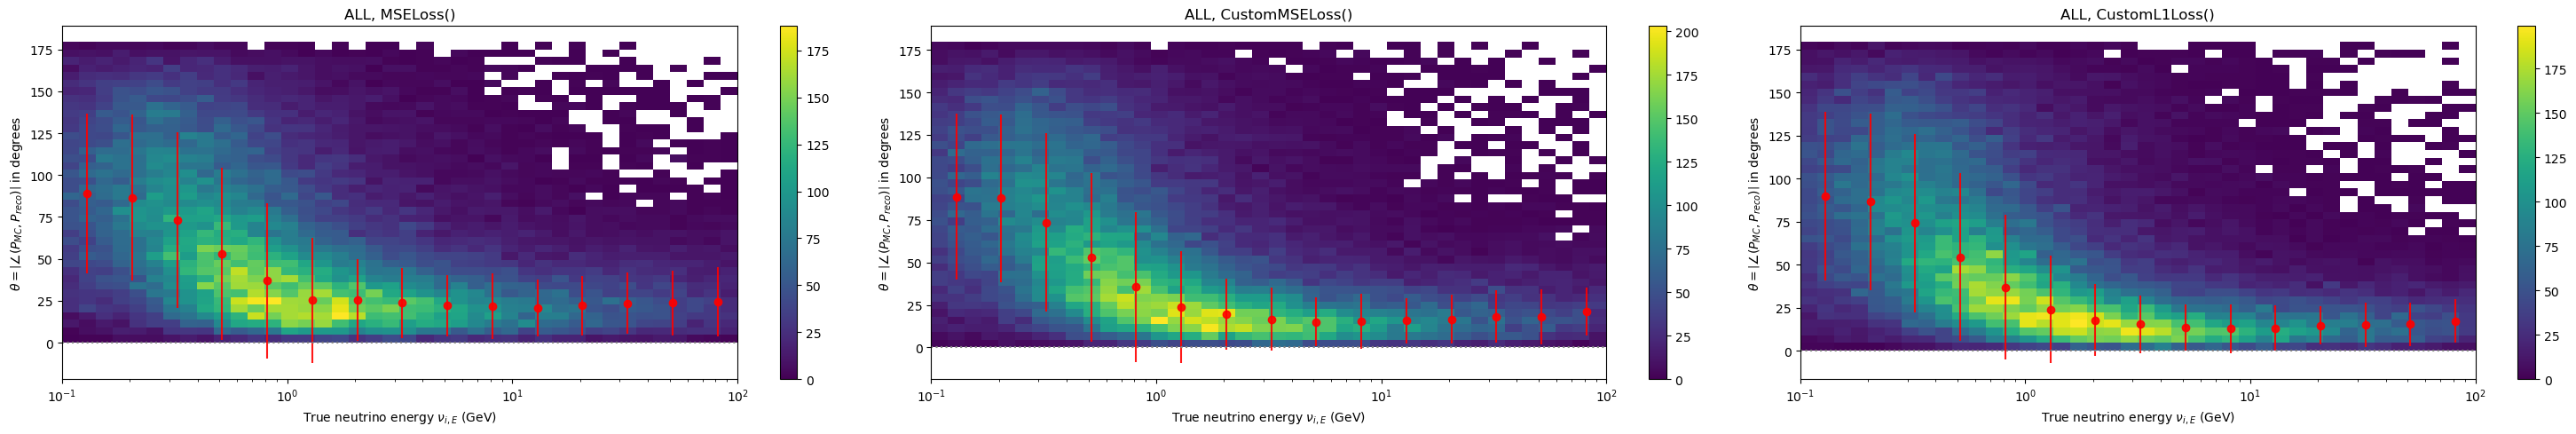

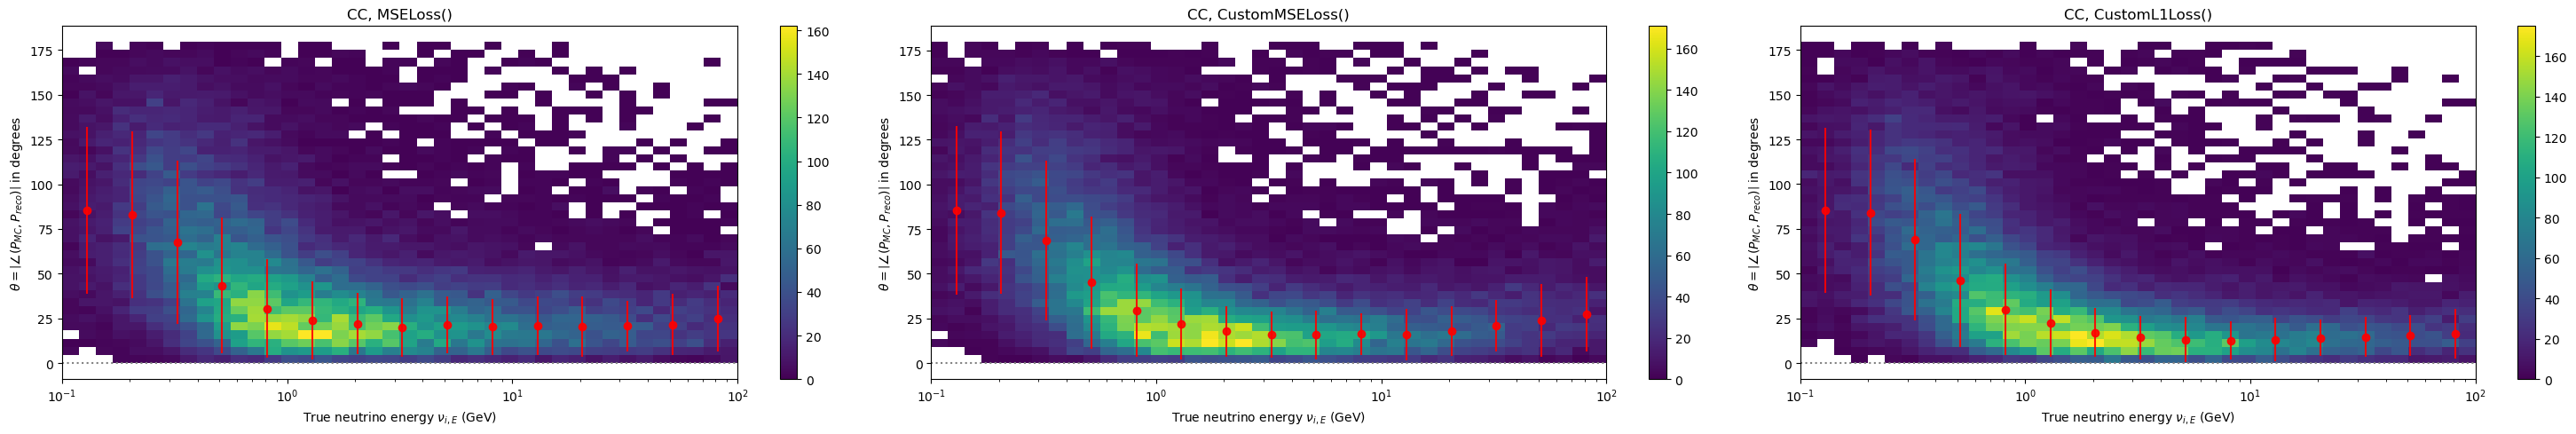

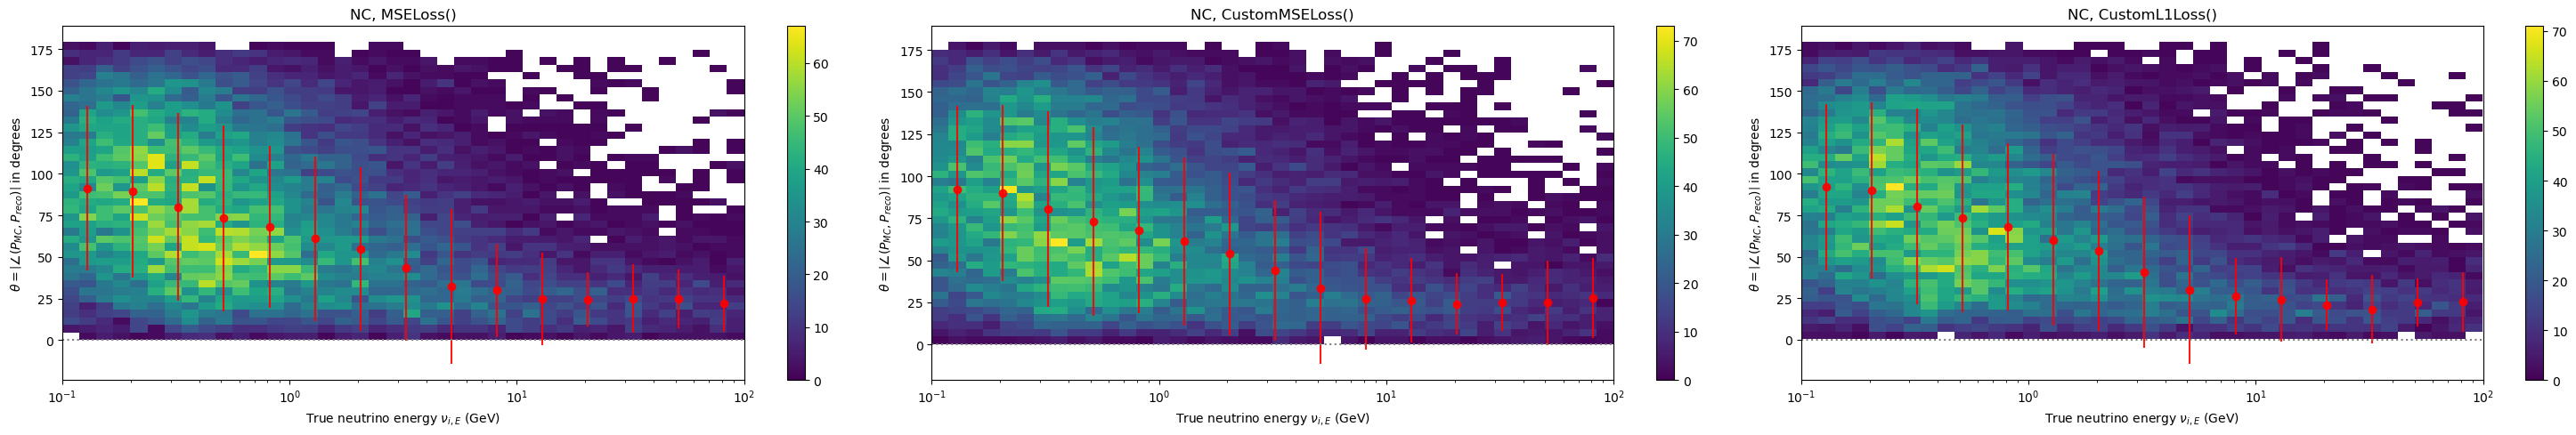

In [14]:
for event_type in ["ALL", "CC", "NC"]:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,5))
    for loss_function, event_type, i in zip([nn.MSELoss(), CustomMSELoss(), CustomL1Loss()], [event_type, event_type, event_type], [0, 1, 2]):
            settings = {
            "event_type": event_type, # "CC", "NC", or "ALL"
            "epochs": 50,
            "batch_size": 100,
            "loss_function": loss_function # nn.MSELoss() or CustomMSELoss() or CustomL1Loss()
            }
    
            model, X_test, y_test = load_model_parameters(settings)
            
            with torch.no_grad():
                y_pred = model(torch.tensor(X_test, dtype=torch.float32))
            
            MCreconu_angle  = calculate_neutrino_angles(y_test, y_pred)
            
            reco_energy = y_test[:,0] - np.array(y_pred[:,0])
            #angle_energy_histograms(MCreconu_angle, reco_energy, "count", ax=ax[0, :])
            angle_reco_binned(ax=ax[i])
    plt.tight_layout()
plt.show()